In [1]:
library(survival)
library(MASS)
library(openxlsx)
library(corrplot)
library(rworldmap)

Warning message:
“package ‘survival’ was built under R version 3.6.2”
corrplot 0.84 loaded

Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')



In [2]:
library(psych)

In [3]:
# 警告メッセージ非表示
options(warn=-1)

In [4]:
df <- read.xlsx("../../data/data_covid_fix_name.xlsx")
df <- na.omit(df)
head(df)

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,2866376,60.319,13364.155,6996524,7.84,8.005411,7.67,70,74.3,1,108641,303.14
2,Algeria,42228429,72.629,15481.788,9108277,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
3,Angola,30809762,65.514,6452.355,10490120,5.40,5.979936,4.83,83,17.9,1,303691,76.94
4,Argentina,44494502,91.870,20610.569,19025624,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
6,Australia,24992369,86.012,51663.365,7608913,8.62,9.160533,8.07,26,97.3,1,1347,75667.65
7,Austria,8847037,58.297,55454.689,7103537,8.48,9.245685,7.71,58,73.2,1,80272,12935.50


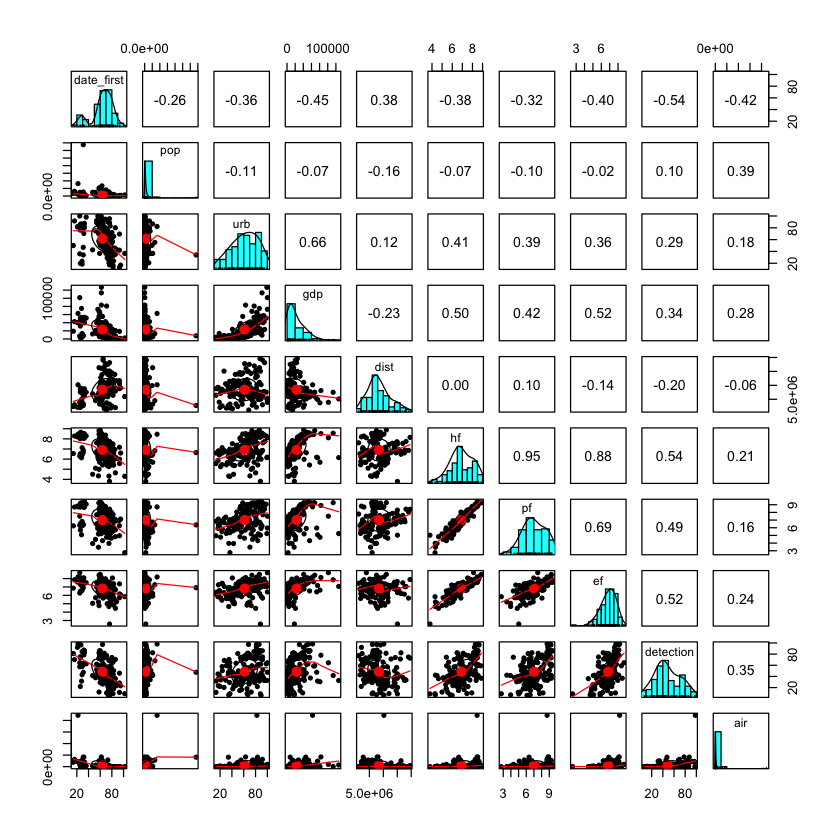

In [5]:
# 正規化なし
pairs.panels(df[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])

In [6]:
# データを感染の大小で分ける
early_country <- df[df$date_first < 40, ]
late_country <- df[df$date_first > 40, ]

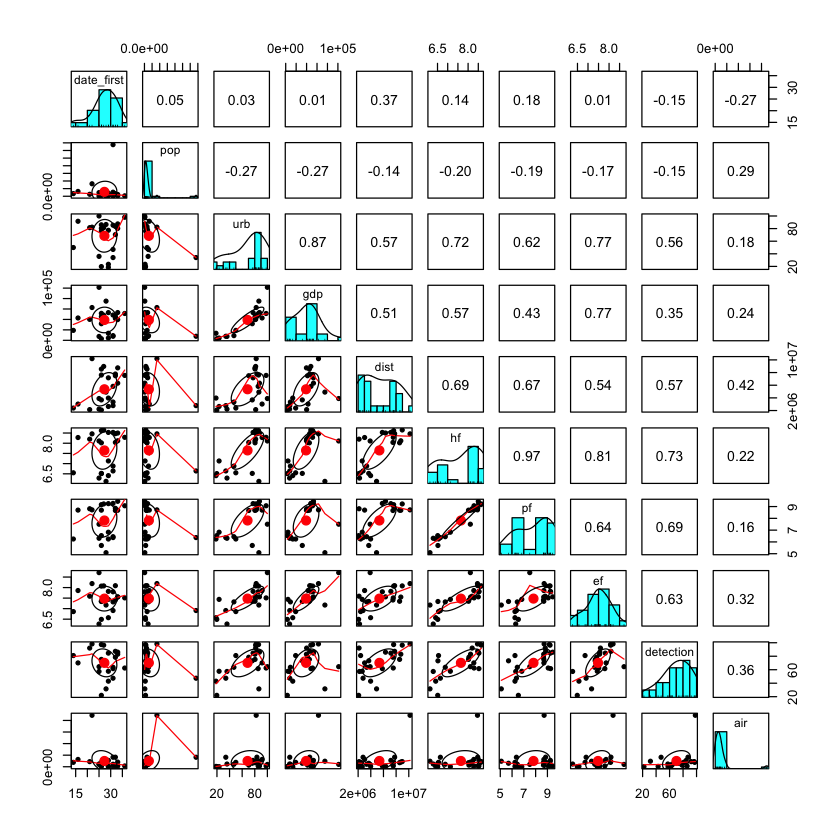

In [7]:
# 正規化なし
pairs.panels(early_country[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])

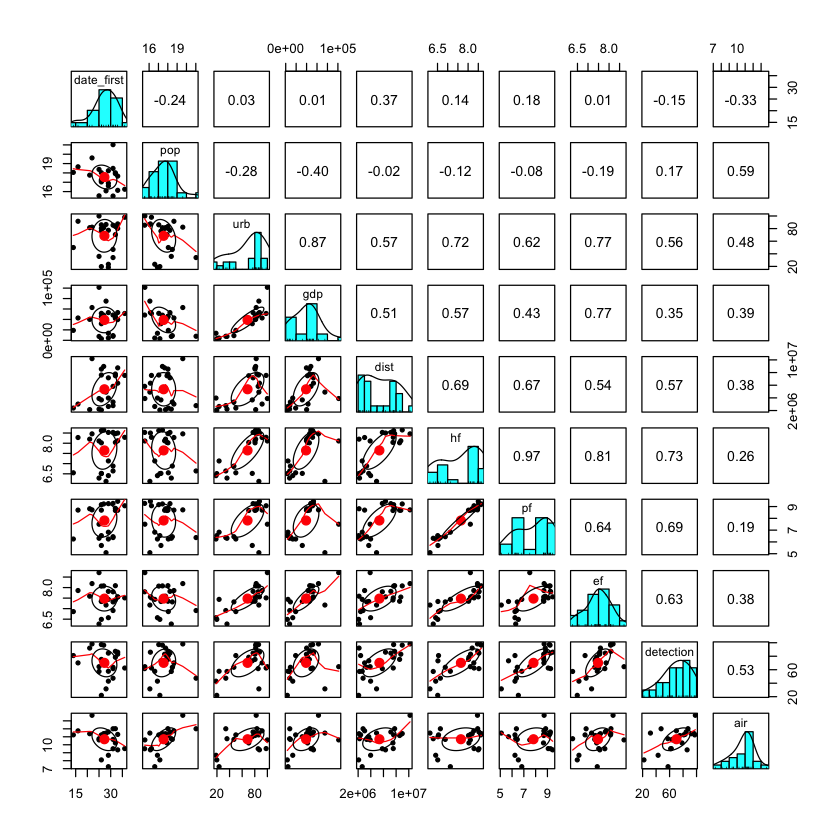

In [8]:
# 正規化あり
tmp <- early_country
tmp$air <- log(tmp$air )
tmp$pop <- log(tmp$pop )
pairs.panels(tmp[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])

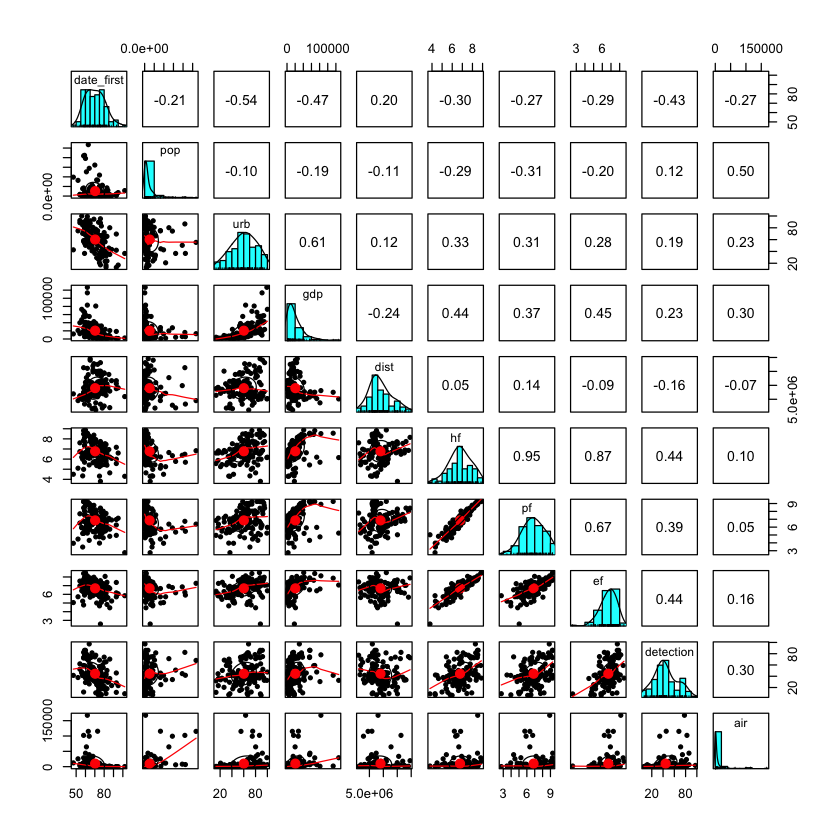

In [9]:
# 正規化なし
pairs.panels(late_country[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])

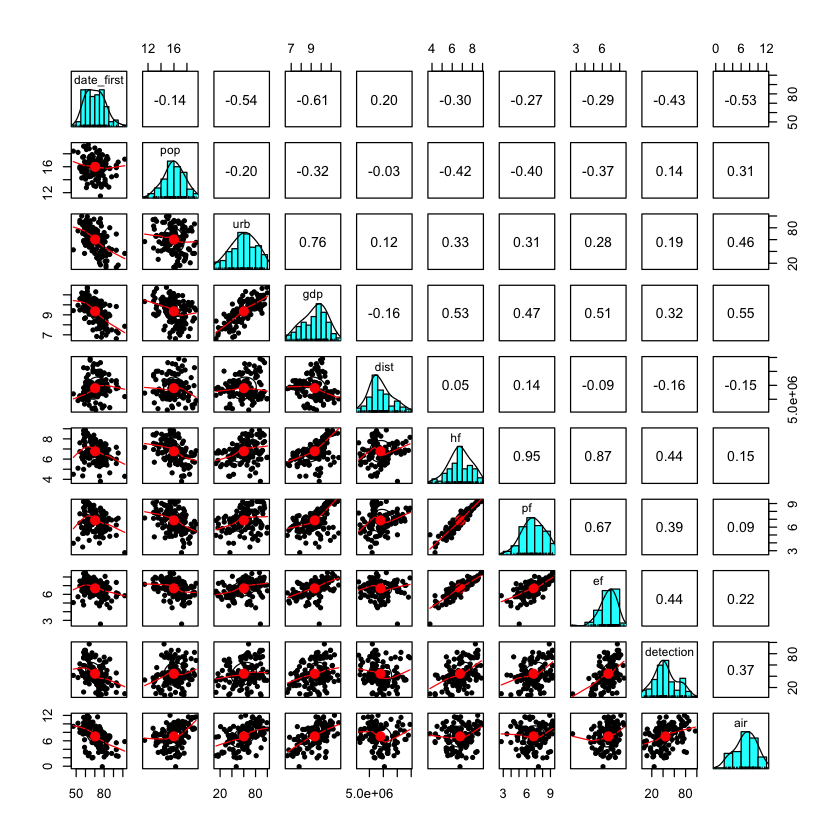

In [10]:
# 正規化あり
tmp <- late_country
tmp$air <- log(tmp$air )
tmp$pop <- log(tmp$pop )
tmp$gdp <- log(tmp$gdp )
pairs.panels(tmp[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])

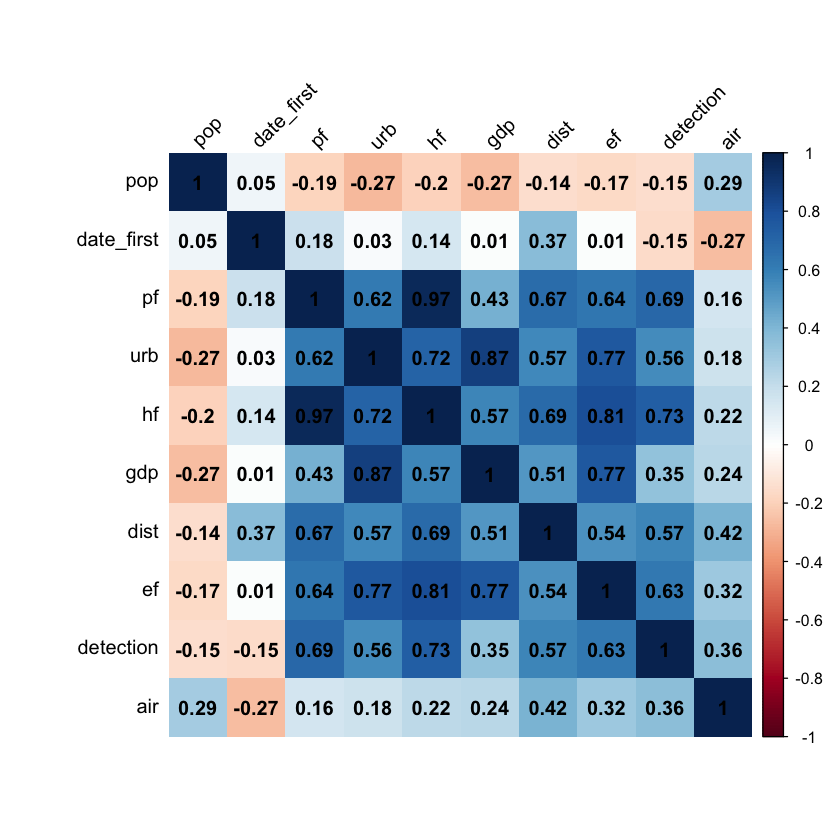

In [11]:
early_cor <- cor(early_country[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])
corrplot(early_cor, method="shade", shade.col=NA, tl.col="black", tl.srt=45,
         addCoef.col="black", order="AOE")

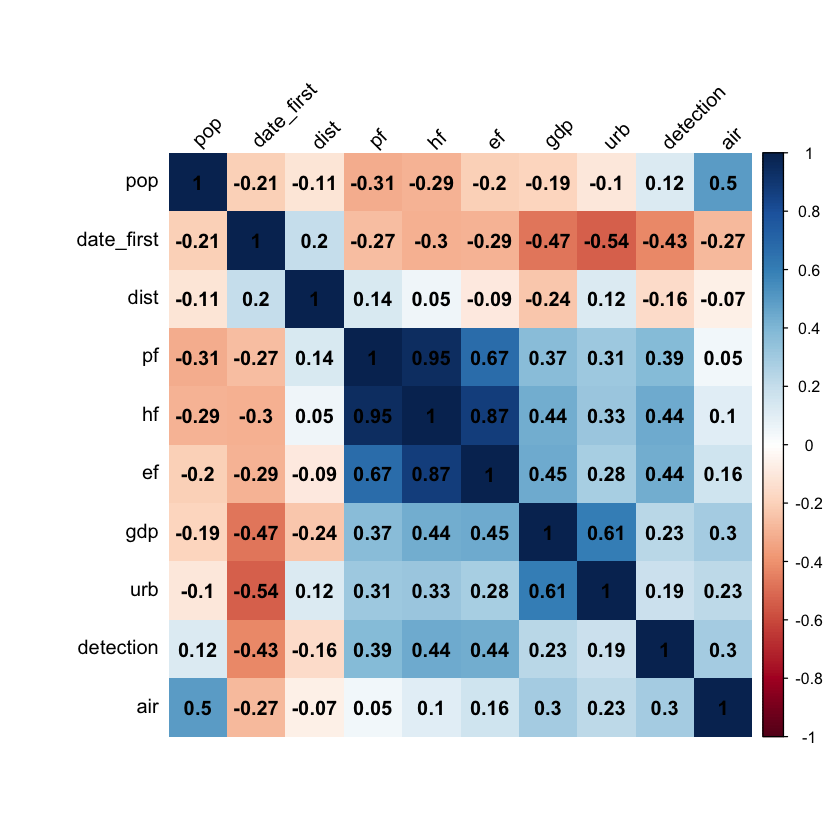

In [12]:
early_cor <- cor(late_country[c('date_first', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'detection', 'air')])
corrplot(early_cor, method="shade", shade.col=NA, tl.col="black", tl.srt=45,
         addCoef.col="black", order="AOE")

# 生存時間解析

In [13]:
Y_early <- Surv(early_country$date_first, early_country$status ==1)
Y_late <- Surv(late_country$date_first, late_country$status ==1)

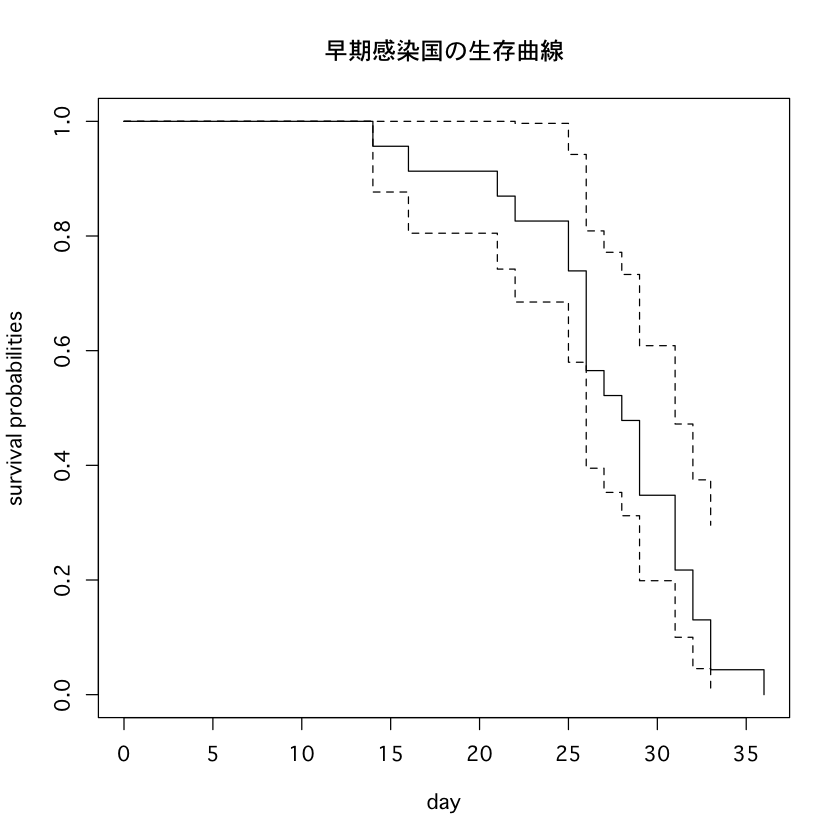

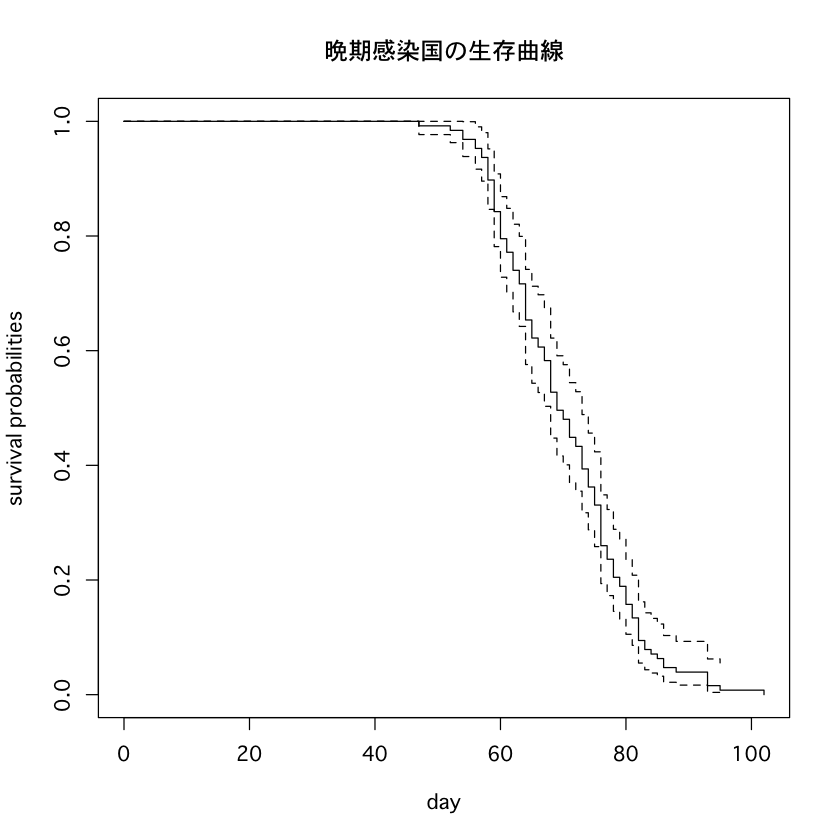

In [14]:
# KM
par(family="Osaka")
kmfit_early = survfit(Y_early ~ 1)
plot(kmfit_early,  mark.t=TRUE, xlab="day", ylab = "survival probabilities", main="早期感染国の生存曲線")

kmfit_late = survfit(Y_late ~ 1)
plot(kmfit_late,  mark.t=TRUE, xlab="day", ylab = "survival probabilities", main="晩期感染国の生存曲線")

## 早期感染国に対してのcox

### 正規化なし

In [15]:
stepAIC(coxph(Y_early ~ hf + pop + gdp + urb + dist + air + detection ,data = early_country))

Start:  AIC=96.86
Y_early ~ hf + pop + gdp + urb + dist + air + detection

            Df     AIC
- hf         1  95.375
- urb        1  95.427
<none>          96.857
- gdp        1  97.096
- pop        1  97.354
- detection  1  97.599
- air        1 101.535
- dist       1 105.566

Step:  AIC=95.38
Y_early ~ pop + gdp + urb + dist + air + detection

            Df     AIC
- urb        1  93.772
- gdp        1  95.167
<none>          95.375
- detection  1  95.908
- pop        1  96.524
- air        1 102.017
- dist       1 107.326

Step:  AIC=93.77
Y_early ~ pop + gdp + dist + air + detection

            Df     AIC
<none>          93.772
- detection  1  93.924
- gdp        1  93.952
- pop        1  95.189
- air        1 101.515
- dist       1 107.632


Call:
coxph(formula = Y_early ~ pop + gdp + dist + air + detection, 
    data = early_country)

                coef  exp(coef)   se(coef)      z        p
pop       -1.505e-09  1.000e+00  9.262e-10 -1.625 0.104223
gdp        1.844e-05  1.000e+00  1.172e-05  1.574 0.115526
dist      -7.272e-07  1.000e+00  1.954e-07 -3.721 0.000199
air        7.115e-06  1.000e+00  2.065e-06  3.445 0.000572
detection  2.307e-02  1.023e+00  1.638e-02  1.408 0.159167

Likelihood ratio test=19.44  on 5 df, p=0.00159
n= 23, number of events= 23 

In [16]:
model_early <-coxph(formula = Y_early ~ pop + gdp + dist + air + detection, data = early_country)
summary(model_early)
AIC(model_early)

Call:
coxph(formula = Y_early ~ pop + gdp + dist + air + detection, 
    data = early_country)

  n= 23, number of events= 23 

                coef  exp(coef)   se(coef)      z Pr(>|z|)    
pop       -1.505e-09  1.000e+00  9.262e-10 -1.625 0.104223    
gdp        1.844e-05  1.000e+00  1.172e-05  1.574 0.115526    
dist      -7.272e-07  1.000e+00  1.954e-07 -3.721 0.000199 ***
air        7.115e-06  1.000e+00  2.065e-06  3.445 0.000572 ***
detection  2.307e-02  1.023e+00  1.638e-02  1.408 0.159167    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
pop           1.000     1.0000     1.000     1.000
gdp           1.000     1.0000     1.000     1.000
dist          1.000     1.0000     1.000     1.000
air           1.000     1.0000     1.000     1.000
detection     1.023     0.9772     0.991     1.057

Concordance= 0.786  (se = 0.07 )
Likelihood ratio test= 19.44  on 5 df,   p=0.002
Wald test            = 15.71  on 5 df

[1] 93.77187

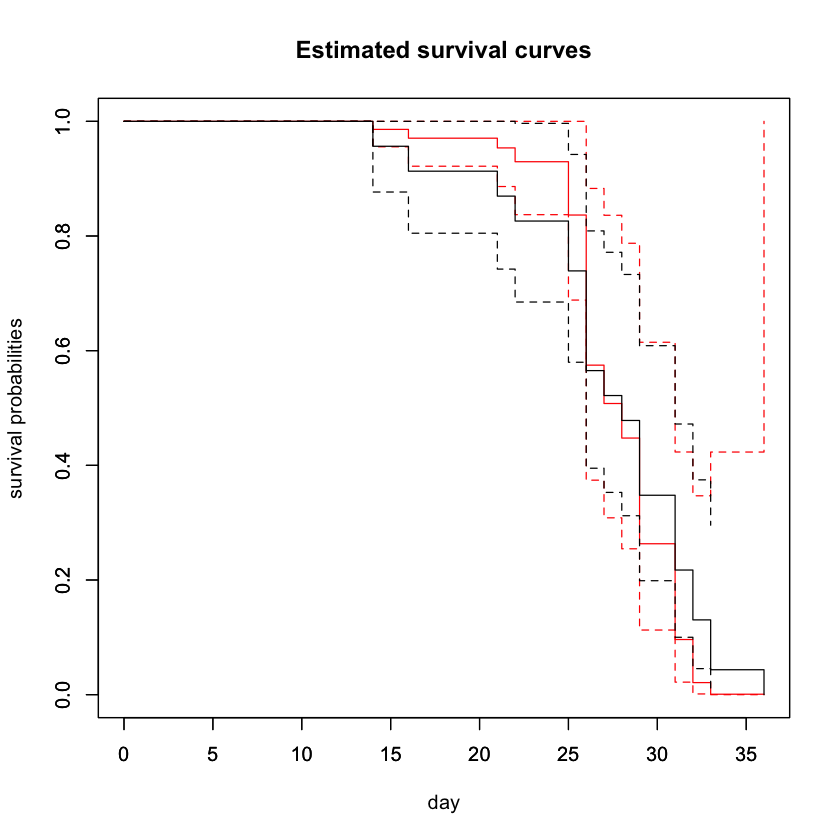

In [17]:
model_early.fit <- survfit(model_early)
plot(model_early.fit, col="red",  xlab="day",  ylab = "survival probabilities", main="Estimated survival curves")

 par(new=T) 
 plot(kmfit_early)  

In [18]:
# 比例ハザード性の確認(シェーンフィールド残差)
# 仮説が棄却されると比例ハザードの仮定が充たされていない可能性があることを示唆する。
#zph_cluster1<- cox.zph(model_early)
#zph_cluster1

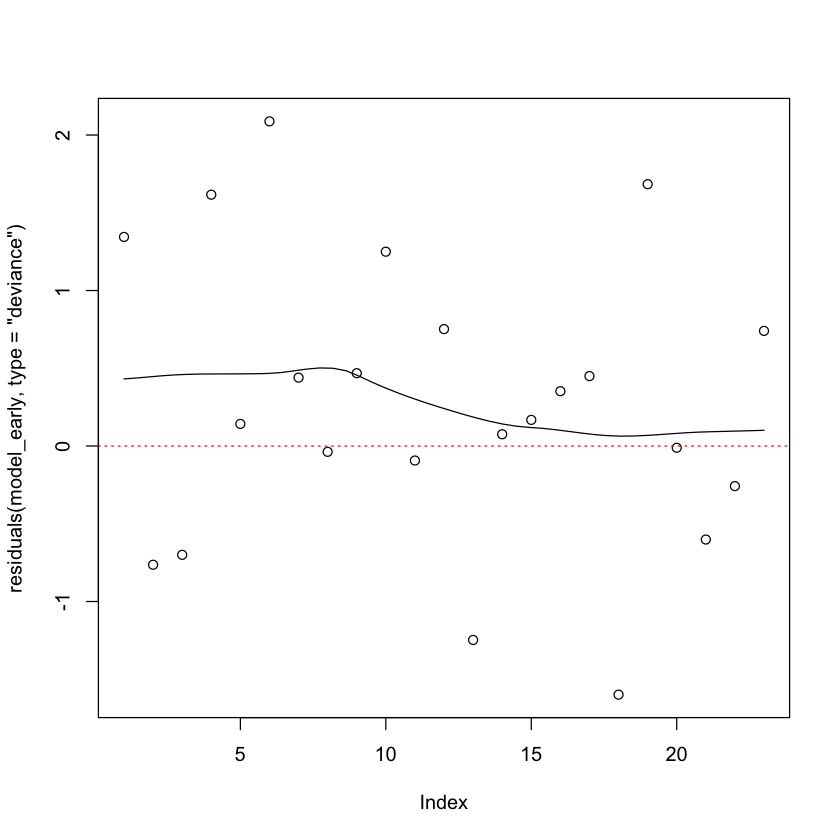

In [19]:
scatter.smooth(residuals(model_early, type="deviance"))
abline(h=0,lty=3,col=2)

23 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
220 codes from the map weren't represented in your data


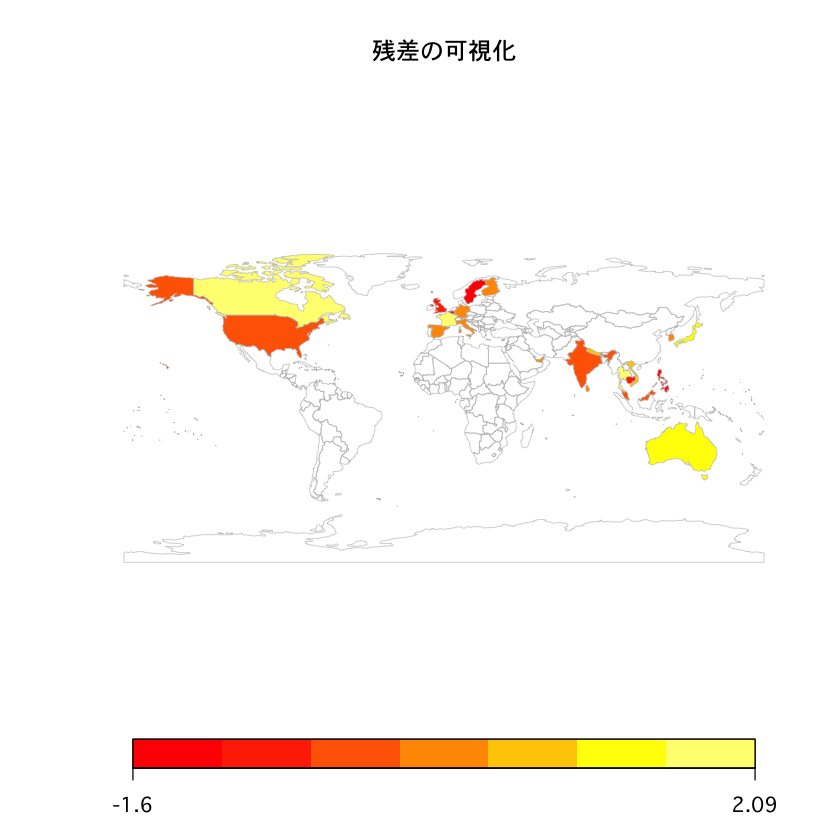

In [20]:
early_country$resid <- residuals(model_early, type="deviance")

map_obj <- joinCountryData2Map(early_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)

### 正規化あり

In [21]:
stepAIC(coxph(Y_early ~ hf + log(pop) + gdp + urb + dist + log(air) + detection ,data = early_country))

Start:  AIC=97.42
Y_early ~ hf + log(pop) + gdp + urb + dist + log(air) + detection

            Df     AIC
- hf         1  95.478
- gdp        1  97.297
<none>          97.425
- detection  1  98.373
- log(pop)   1  98.601
- log(air)   1 100.567
- urb        1 101.334
- dist       1 105.284

Step:  AIC=95.48
Y_early ~ log(pop) + gdp + urb + dist + log(air) + detection

            Df     AIC
<none>          95.478
- gdp        1  96.169
- log(pop)   1  97.523
- urb        1  99.534
- log(air)   1 100.686
- detection  1 100.940
- dist       1 104.623


Call:
coxph(formula = Y_early ~ log(pop) + gdp + urb + dist + log(air) + 
    detection, data = early_country)

                coef  exp(coef)   se(coef)      z       p
log(pop)  -9.439e-01  3.891e-01  4.891e-01 -1.930 0.05364
gdp        4.161e-05  1.000e+00  2.510e-05  1.658 0.09731
urb       -8.306e-02  9.203e-01  3.562e-02 -2.332 0.01970
dist      -5.576e-07  1.000e+00  1.721e-07 -3.241 0.00119
log(air)   1.268e+00  3.552e+00  5.016e-01  2.527 0.01151
detection  5.611e-02  1.058e+00  2.313e-02  2.426 0.01528

Likelihood ratio test=19.74  on 6 df, p=0.003086
n= 23, number of events= 23 

In [22]:
model_early <- coxph(formula = Y_early ~ log(pop) + gdp + urb + dist + log(air) + detection, data = early_country)
summary(model_early)
AIC(model_early)

Call:
coxph(formula = Y_early ~ log(pop) + gdp + urb + dist + log(air) + 
    detection, data = early_country)

  n= 23, number of events= 23 

                coef  exp(coef)   se(coef)      z Pr(>|z|)   
log(pop)  -9.439e-01  3.891e-01  4.891e-01 -1.930  0.05364 . 
gdp        4.161e-05  1.000e+00  2.510e-05  1.658  0.09731 . 
urb       -8.306e-02  9.203e-01  3.562e-02 -2.332  0.01970 * 
dist      -5.576e-07  1.000e+00  1.721e-07 -3.241  0.00119 **
log(air)   1.268e+00  3.552e+00  5.016e-01  2.527  0.01151 * 
detection  5.611e-02  1.058e+00  2.313e-02  2.426  0.01528 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
log(pop)     0.3891     2.5700    0.1492    1.0149
gdp          1.0000     1.0000    1.0000    1.0001
urb          0.9203     1.0866    0.8582    0.9868
dist         1.0000     1.0000    1.0000    1.0000
log(air)     3.5521     0.2815    1.3290    9.4940
detection    1.0577     0.9454    1.0108    1.10

[1] 95.47802

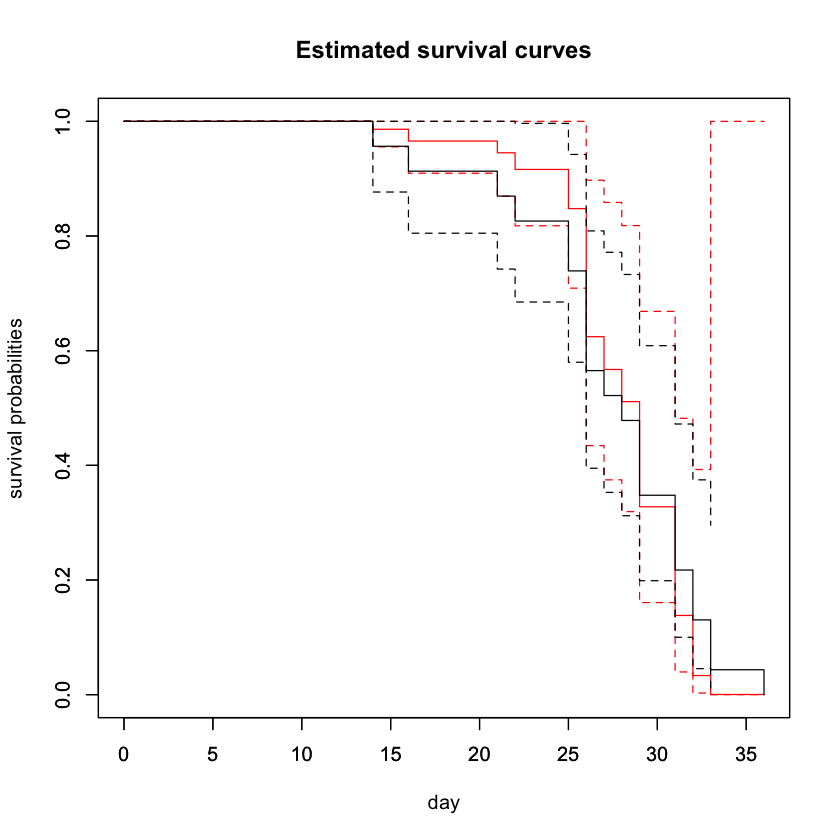

In [23]:
model_early.fit <- survfit(model_early)
plot(model_early.fit, col="red",  xlab="day",  ylab = "survival probabilities", main="Estimated survival curves")

 par(new=T) 
 plot(kmfit_early)     

In [24]:
# 比例ハザード性の確認(シェーンフィールド残差)
# 仮説が棄却されると比例ハザードの仮定が充たされていない可能性があることを示唆する。
zph_cluster1<- cox.zph(model_early)
zph_cluster1

            chisq df    p
log(pop)  0.74188  1 0.39
gdp       0.00845  1 0.93
urb       1.09748  1 0.29
dist      0.10559  1 0.75
log(air)  1.32184  1 0.25
detection 3.28004  1 0.07
GLOBAL    8.52631  6 0.20

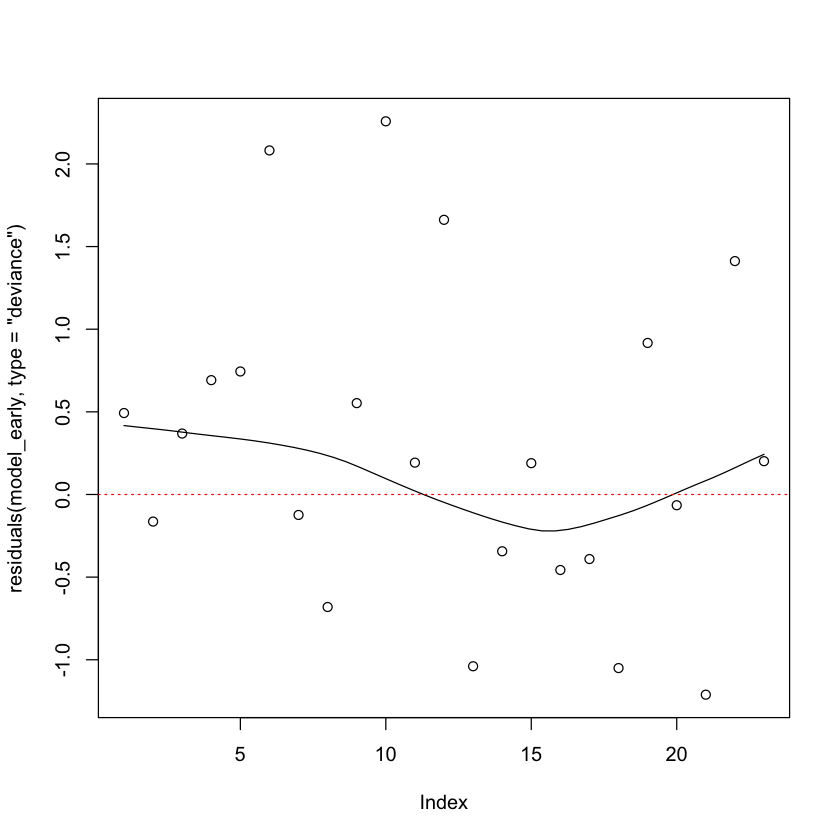

In [25]:
scatter.smooth(residuals(model_early, type="deviance"))
abline(h=0,lty=3,col=2)

23 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
220 codes from the map weren't represented in your data


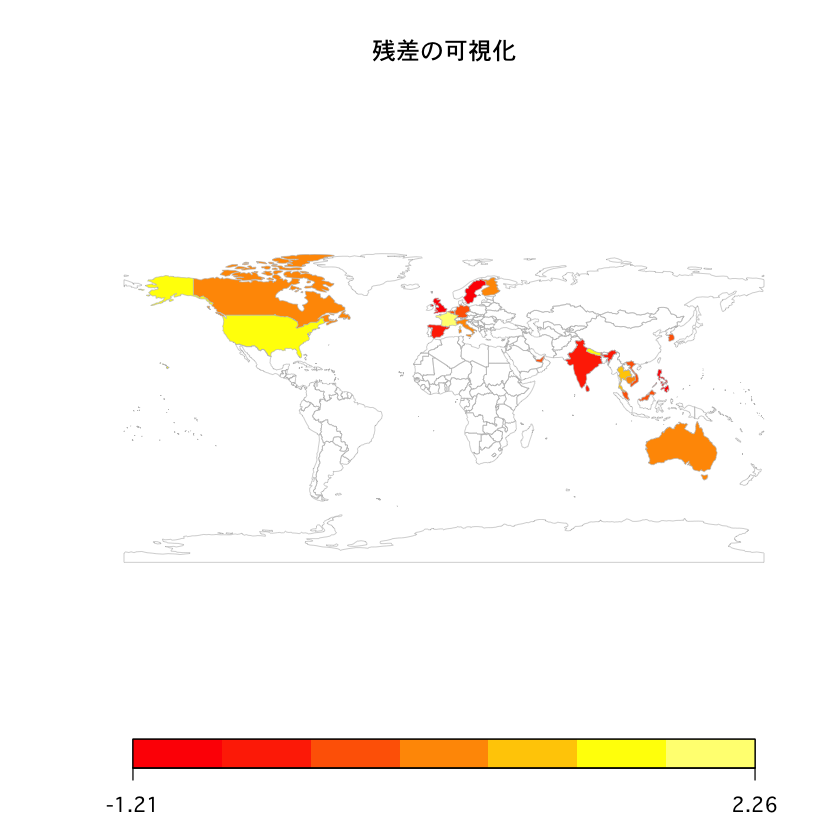

In [26]:
early_country$resid <- residuals(model_early, type="deviance")

map_obj <- joinCountryData2Map(early_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)

## 晩期感染国に対してのcox

### 正規化なし

In [27]:
stepAIC(coxph(Y_late ~ hf + pop + gdp + urb + dist + air + detection ,data = late_country))

Start:  AIC=907.05
Y_late ~ hf + pop + gdp + urb + dist + air + detection

            Df    AIC
- dist       1 906.30
- air        1 906.92
<none>         907.05
- hf         1 911.38
- gdp        1 913.10
- detection  1 916.09
- urb        1 919.25
- pop        1 922.07

Step:  AIC=906.3
Y_late ~ hf + pop + gdp + urb + air + detection

            Df    AIC
- air        1 906.21
<none>         906.30
- hf         1 909.76
- detection  1 917.22
- urb        1 917.79
- gdp        1 917.88
- pop        1 922.56

Step:  AIC=906.21
Y_late ~ hf + pop + gdp + urb + detection

            Df    AIC
<none>         906.21
- hf         1 909.26
- detection  1 915.94
- gdp        1 916.02
- urb        1 917.02
- pop        1 921.86


Call:
coxph(formula = Y_late ~ hf + pop + gdp + urb + detection, data = late_country)

               coef exp(coef)  se(coef)     z        p
hf        2.372e-01 1.268e+00 1.087e-01 2.183 0.029064
pop       1.036e-08 1.000e+00 2.069e-09 5.006 5.55e-07
gdp       1.962e-05 1.000e+00 5.143e-06 3.814 0.000137
urb       1.936e-02 1.020e+00 5.410e-03 3.579 0.000345
detection 1.751e-02 1.018e+00 5.022e-03 3.486 0.000490

Likelihood ratio test=86.9  on 5 df, p=< 2.2e-16
n= 127, number of events= 127 

In [28]:
model_late <- coxph(formula = Y_late ~ hf + pop + gdp + urb + detection, data = late_country)
summary(model_late)
AIC(model_late)

Call:
coxph(formula = Y_late ~ hf + pop + gdp + urb + detection, data = late_country)

  n= 127, number of events= 127 

               coef exp(coef)  se(coef)     z Pr(>|z|)    
hf        2.372e-01 1.268e+00 1.087e-01 2.183 0.029064 *  
pop       1.036e-08 1.000e+00 2.069e-09 5.006 5.55e-07 ***
gdp       1.962e-05 1.000e+00 5.143e-06 3.814 0.000137 ***
urb       1.936e-02 1.020e+00 5.410e-03 3.579 0.000345 ***
detection 1.751e-02 1.018e+00 5.022e-03 3.486 0.000490 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
hf            1.268     0.7888     1.024     1.569
pop           1.000     1.0000     1.000     1.000
gdp           1.000     1.0000     1.000     1.000
urb           1.020     0.9808     1.009     1.030
detection     1.018     0.9826     1.008     1.028

Concordance= 0.762  (se = 0.018 )
Likelihood ratio test= 86.9  on 5 df,   p=<2e-16
Wald test            = 76.34  on 5 df,   p=5e-15
Score (logrank) te

[1] 906.2091

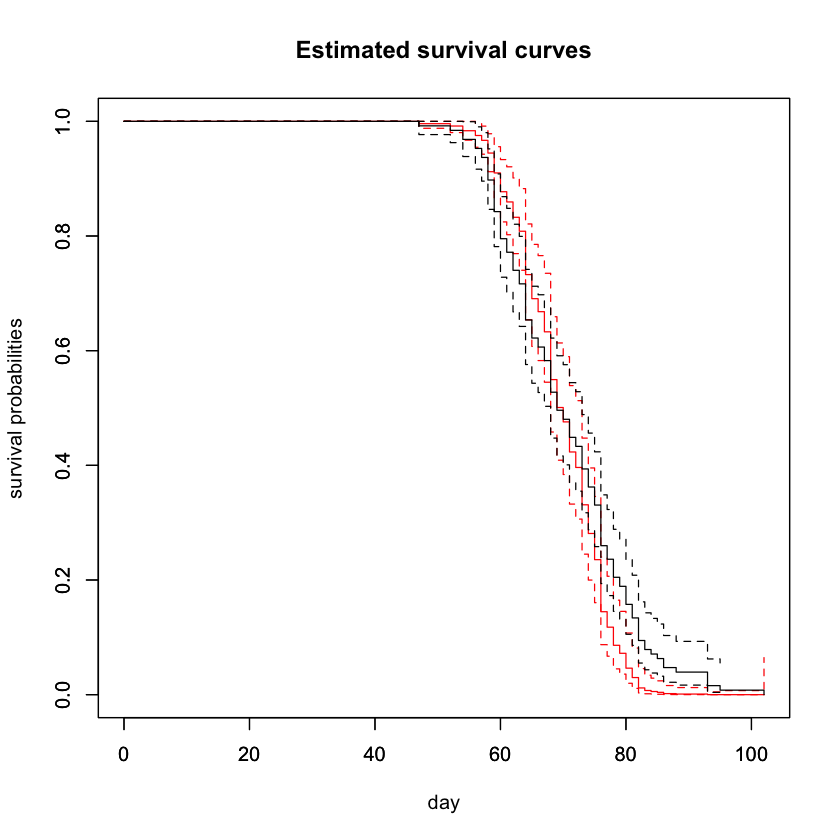

In [29]:
model_late.fit <- survfit(model_late)
plot(model_late.fit, col="red",  xlab="day",  ylab = "survival probabilities", main="Estimated survival curves")

par(new=T) 
plot(kmfit_late)     

In [30]:
#zph_cluster2<- cox.zph(model_late)
#zph_cluster2

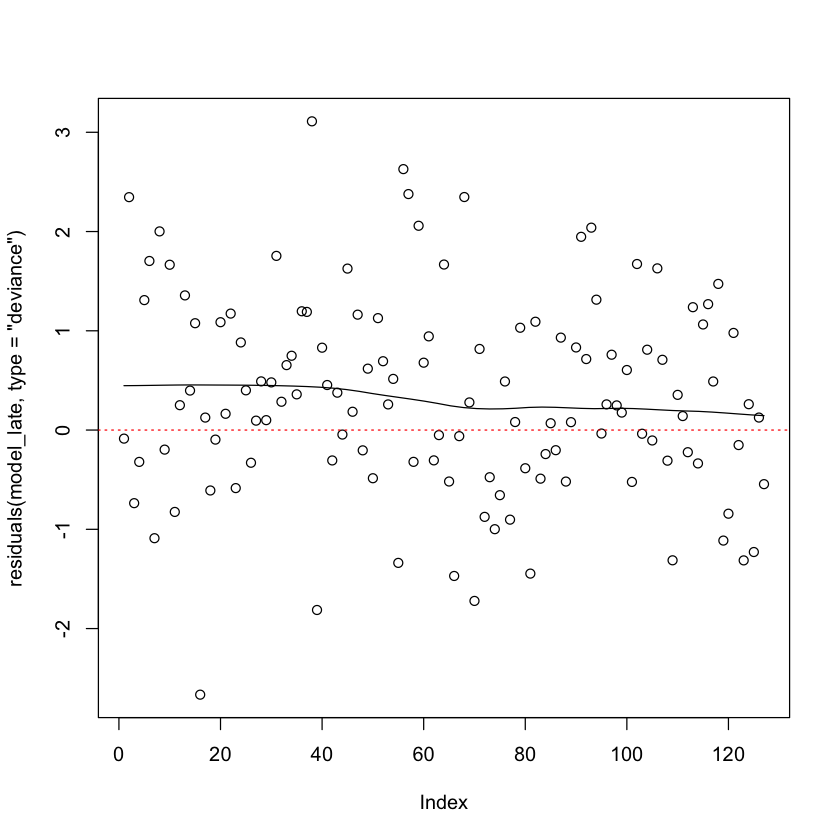

In [31]:
scatter.smooth(residuals(model_late, type="deviance"))
abline(h=0,lty=3,col=2)

126 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
117 codes from the map weren't represented in your data


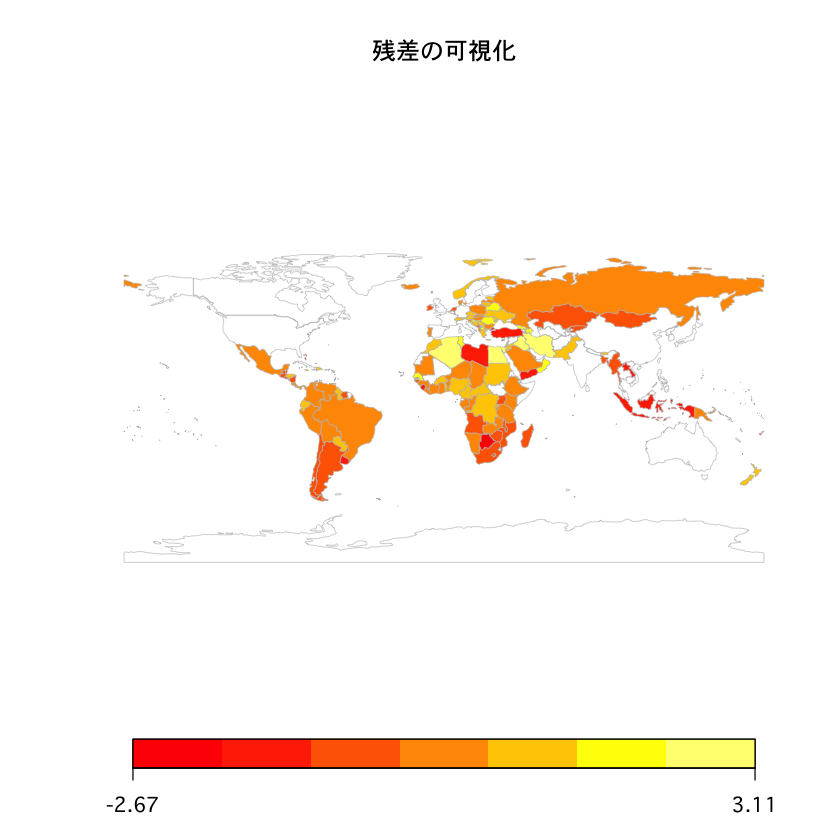

In [32]:
late_country$resid <- residuals(model_late, type="deviance")

map_obj <- joinCountryData2Map(late_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)

### 正規化あり

In [33]:
stepAIC(coxph(Y_late ~ hf + log(pop) + log(gdp) + urb + dist + log(air) + detection ,data = late_country))

Start:  AIC=905.73
Y_late ~ hf + log(pop) + log(gdp) + urb + dist + log(air) + detection

            Df    AIC
- log(air)   1 903.85
<none>         905.73
- dist       1 906.15
- detection  1 906.46
- log(gdp)   1 907.46
- urb        1 908.89
- hf         1 913.36
- log(pop)   1 918.66

Step:  AIC=903.85
Y_late ~ hf + log(pop) + log(gdp) + urb + dist + detection

            Df    AIC
<none>         903.85
- dist       1 904.31
- detection  1 904.97
- urb        1 906.98
- log(gdp)   1 907.35
- hf         1 911.43
- log(pop)   1 923.11


Call:
coxph(formula = Y_late ~ hf + log(pop) + log(gdp) + urb + dist + 
    detection, data = late_country)

                coef  exp(coef)   se(coef)      z        p
hf         3.815e-01  1.465e+00  1.284e-01  2.972  0.00296
log(pop)   3.493e-01  1.418e+00  7.644e-02  4.570 4.87e-06
log(gdp)   4.096e-01  1.506e+00  1.761e-01  2.326  0.02003
urb        1.942e-02  1.020e+00  8.659e-03  2.242  0.02493
dist      -4.357e-08  1.000e+00  2.788e-08 -1.563  0.11806
detection  9.401e-03  1.009e+00  5.278e-03  1.781  0.07492

Likelihood ratio test=91.25  on 6 df, p=< 2.2e-16
n= 127, number of events= 127 

In [34]:
model_late <- coxph(formula = Y_late ~ hf + log(pop) + log(gdp) + urb + dist + detection, data = late_country)


summary(model_late)
AIC(model_late)

Call:
coxph(formula = Y_late ~ hf + log(pop) + log(gdp) + urb + dist + 
    detection, data = late_country)

  n= 127, number of events= 127 

                coef  exp(coef)   se(coef)      z Pr(>|z|)    
hf         3.815e-01  1.465e+00  1.284e-01  2.972  0.00296 ** 
log(pop)   3.493e-01  1.418e+00  7.644e-02  4.570 4.87e-06 ***
log(gdp)   4.096e-01  1.506e+00  1.761e-01  2.326  0.02003 *  
urb        1.942e-02  1.020e+00  8.659e-03  2.242  0.02493 *  
dist      -4.357e-08  1.000e+00  2.788e-08 -1.563  0.11806    
detection  9.401e-03  1.009e+00  5.278e-03  1.781  0.07492 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
hf            1.465     0.6828    1.1388     1.883
log(pop)      1.418     0.7052    1.2208     1.647
log(gdp)      1.506     0.6639    1.0666     2.127
urb           1.020     0.9808    1.0024     1.037
dist          1.000     1.0000    1.0000     1.000
detection     1.009     0.9906    0.9991  

[1] 903.853

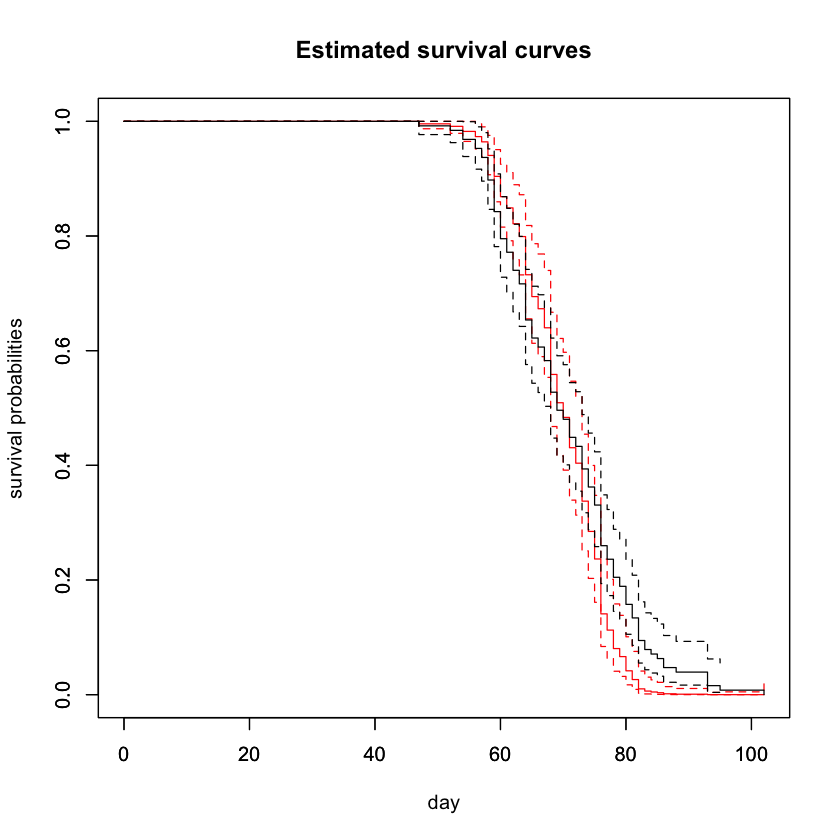

In [35]:
model_late.fit <- survfit(model_late)
plot(model_late.fit, col="red", xlab="day",  ylab = "survival probabilities", main="Estimated survival curves")

 par(new=T) 
 plot(kmfit_late)   

In [36]:
# 比例ハザード性の確認(シェーンフィールド残差)
# 仮説が棄却されると比例ハザードの仮定が充たされていない可能性があることを示唆する。
zph_cluster2<- cox.zph(model_late)
zph_cluster2

           chisq df      p
hf         2.390  1 0.1221
log(pop)   0.121  1 0.7277
log(gdp)   5.975  1 0.0145
urb        3.711  1 0.0541
dist       7.555  1 0.0060
detection  0.085  1 0.7706
GLOBAL    18.820  6 0.0045

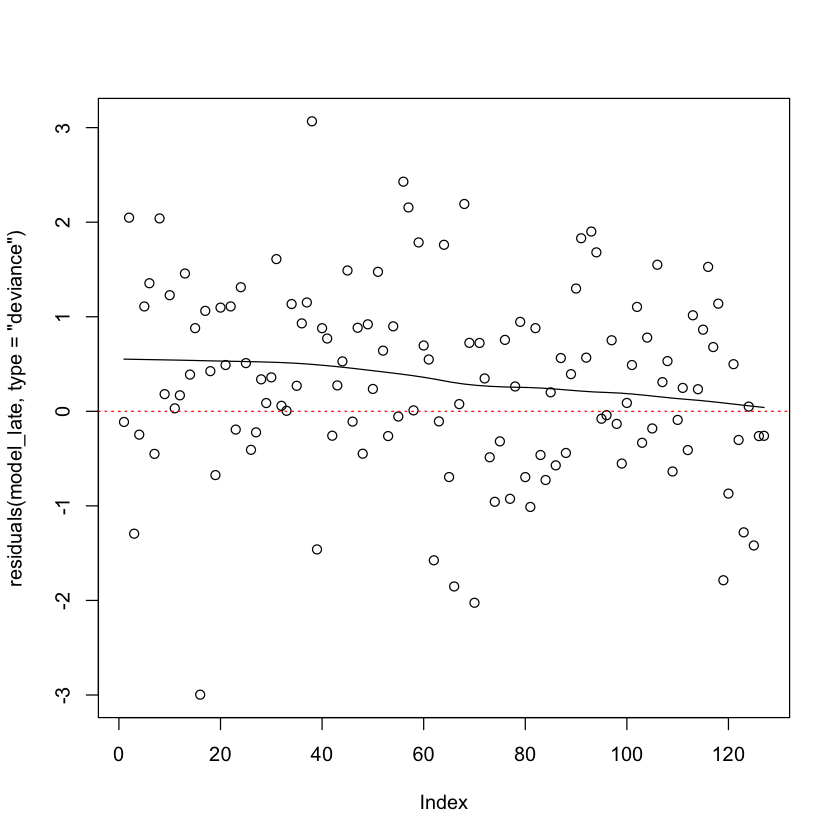

In [37]:
scatter.smooth(residuals(model_late, type="deviance"))
abline(h=0,lty=3,col=2)

126 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
117 codes from the map weren't represented in your data


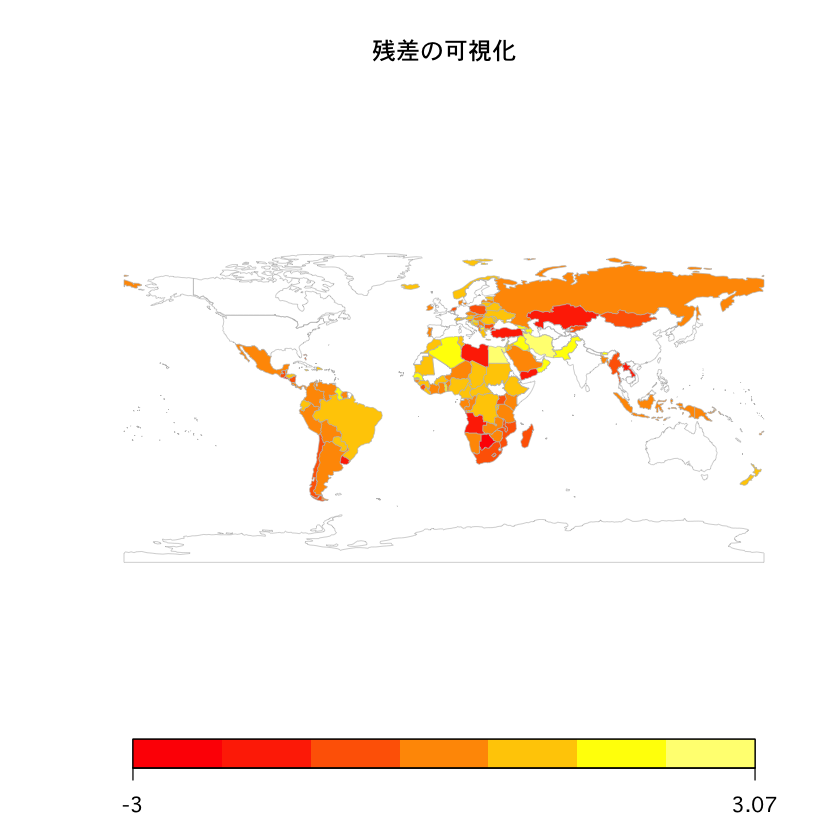

In [38]:
late_country$resid <- residuals(model_late, type="deviance")

map_obj <- joinCountryData2Map(late_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)

# 重回帰分析

### 早期感染国

In [39]:
step(lm(formula = date_first ~ hf + log(pop) + gdp+ urb + dist + log(air) + detection , data = early_country))

Start:  AIC=75.5
date_first ~ hf + log(pop) + gdp + urb + dist + log(air) + detection

            Df Sum of Sq    RSS    AIC
- hf         1     1.442 307.15 73.612
- gdp        1     3.856 309.56 73.792
- log(pop)   1     7.210 312.91 74.040
- urb        1    19.152 324.86 74.902
- detection  1    24.234 329.94 75.259
<none>                   305.71 75.504
- log(air)   1    28.183 333.89 75.532
- dist       1   178.704 484.41 84.091

Step:  AIC=73.61
date_first ~ log(pop) + gdp + urb + dist + log(air) + detection

            Df Sum of Sq    RSS    AIC
- log(pop)   1     5.940 313.09 72.053
- gdp        1     6.545 313.69 72.097
- urb        1    19.681 326.83 73.041
<none>                   307.15 73.612
- log(air)   1    37.773 344.92 74.280
- detection  1    58.703 365.85 75.635
- dist       1   193.354 500.50 82.843

Step:  AIC=72.05
date_first ~ gdp + urb + dist + log(air) + detection

            Df Sum of Sq    RSS    AIC
- urb        1    15.194 328.28 71.143
- gdp        1   


Call:
lm(formula = date_first ~ dist + log(air) + detection, data = early_country)

Coefficients:
(Intercept)         dist     log(air)    detection  
  4.257e+01    1.484e-06   -1.573e+00   -9.115e-02  


In [40]:
lm_early <- lm(formula = date_first ~ dist + log(air) + detection, data = early_country)
summary(lm_early)
AIC(lm_early)


Call:
lm(formula = date_first ~ dist + log(air) + detection, data = early_country)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0553 -2.0220  0.3483  2.3807  7.5205 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.257e+01  6.805e+00   6.256 5.24e-06 ***
dist         1.484e-06  4.164e-07   3.565  0.00207 ** 
log(air)    -1.573e+00  7.416e-01  -2.121  0.04726 *  
detection   -9.115e-02  5.781e-02  -1.577  0.13137    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.19 on 19 degrees of freedom
Multiple R-squared:  0.4663,	Adjusted R-squared:  0.382 
F-statistic: 5.533 on 3 and 19 DF,  p-value: 0.006665


[1] 136.7773

### 解釈
- 1. 残差(y)と予測値(x)......残差のふるまい  
横軸：予測値、縦軸：残差  
相対的に大きい残差には番号がふられる  
- 2. 正規Q-Qプロット.....正規性の検証  
残差が正規分布に従っている
⇒点が直線上に並べられる。  
- 3. 規準化残差と予測値.....残差の大きさ  
縦軸 ： 規準化した残差の絶対値の平方根、横軸 ： 予測値　　
  
### 仮定  
残差の正規性  
残差の期待値は０  
残差の分散は等しい    
それぞれの残差は互いに独立  
   
参考：https://statistics.co.jp/reference/software_R/statR_6_reg2.pdf

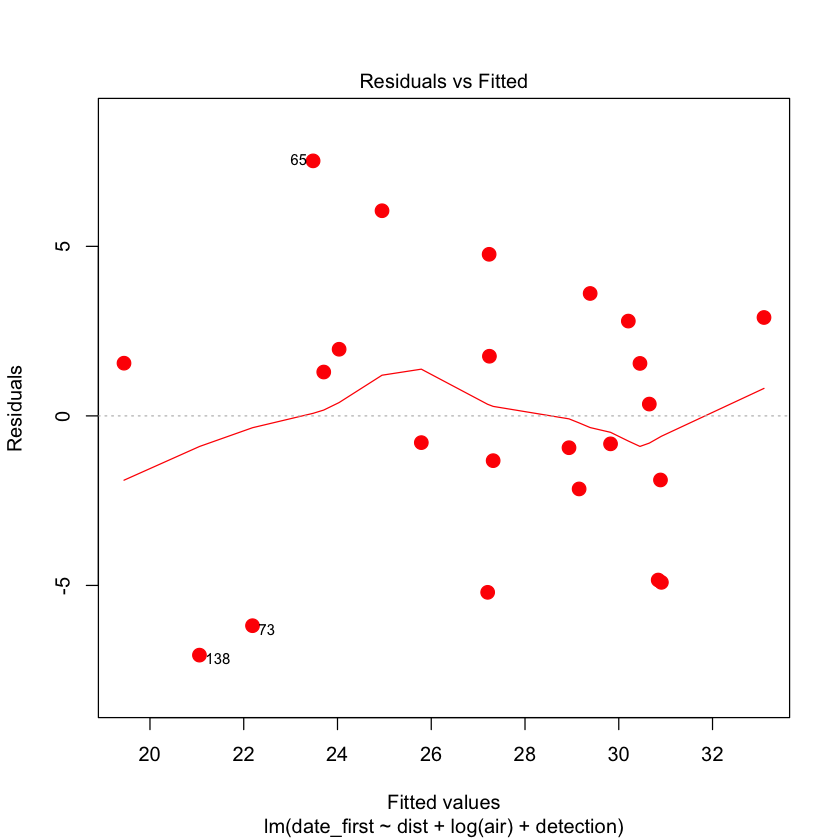

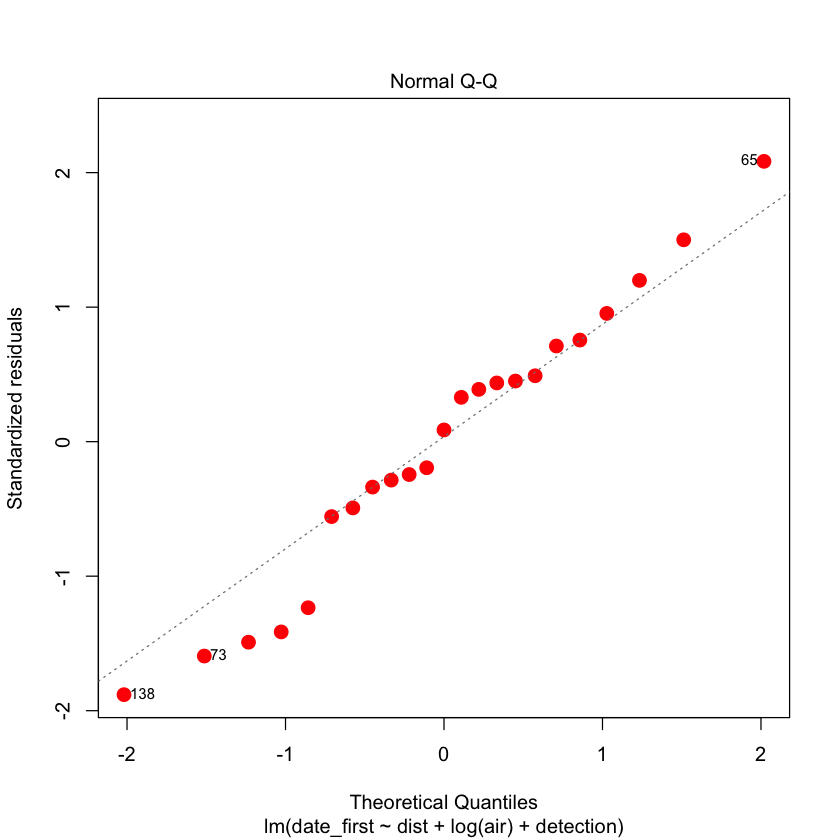

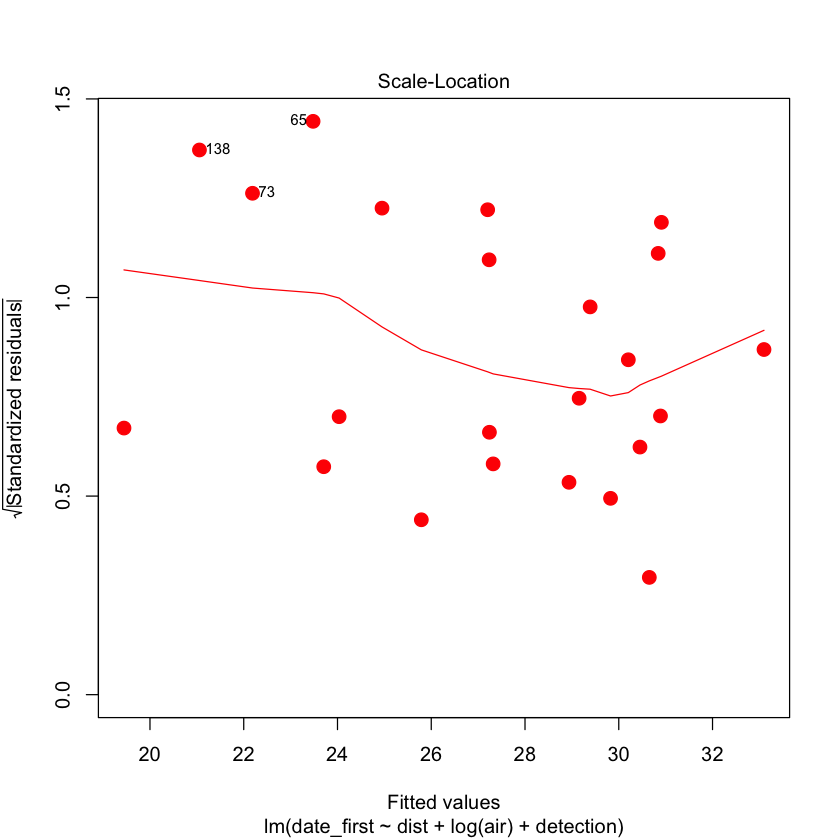

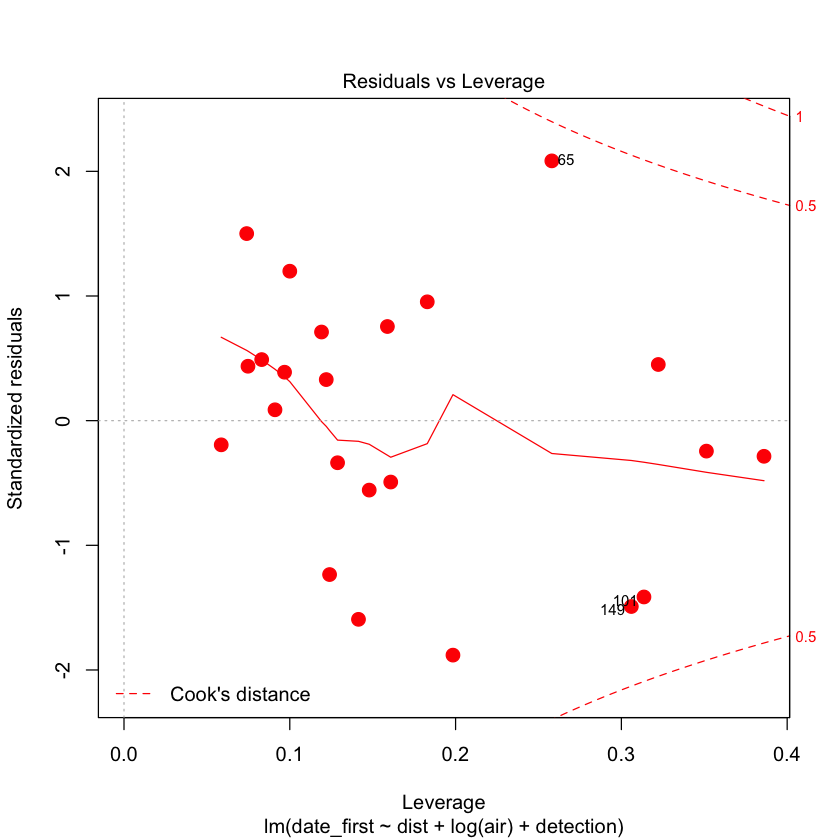

In [41]:
plot(lm_early,pch=21,bg=2,col=2,cex=1.5)

### 可視化からの考察  
- 残差はIndia(65). Japan(73), Thailand(138)が相対的に外れている

23 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
220 codes from the map weren't represented in your data


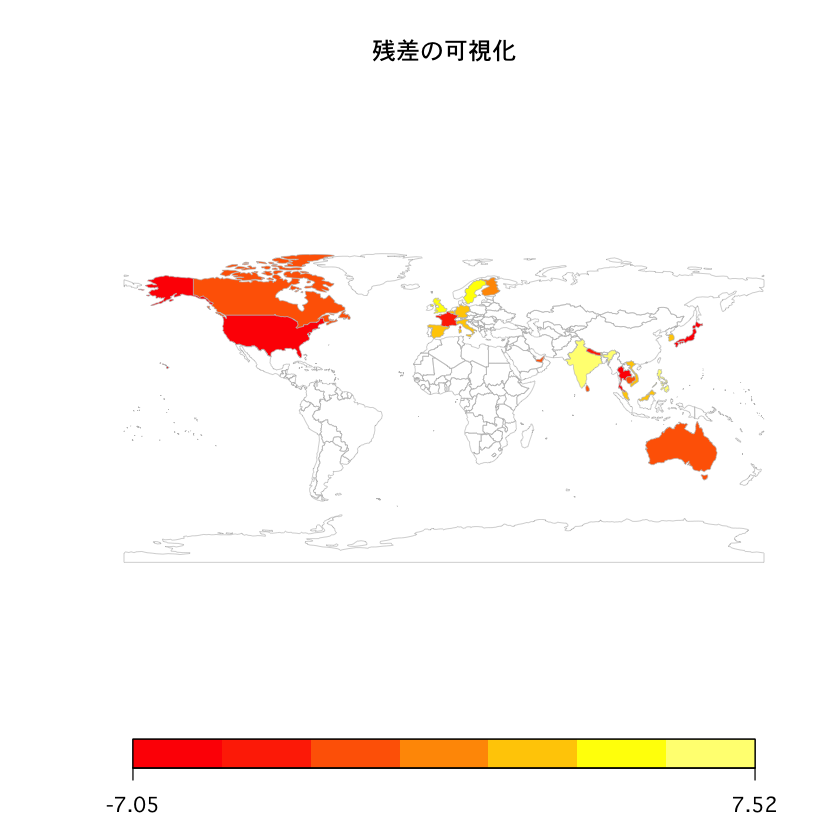

In [42]:
early_country$resid <- residuals(lm_early)

map_obj <- joinCountryData2Map(early_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)

In [50]:
early_country$pred <- predict(lm_early)
early_country

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air,resid,resid_abs,pred
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,Australia,24992369,86.012,51663.365,7608913,8.62,9.160533,8.07,26,97.3,1,1347,75667.65,-1.3203788,1.3203788,27.32038
14,Belgium,11422068,98.001,51407.998,7548354,8.29,9.067695,7.51,36,62.5,1,20605,13639.49,2.9019278,2.9019278,33.09807
26,Cambodia,16249798,23.388,4360.854,2643780,7.13,6.824764,7.44,29,57.7,1,4580,1411.06,-0.8245937,0.8245937,29.82459
28,Canada,37058856,81.411,48130.256,8965622,8.65,9.222964,8.08,27,96.4,1,2020,89380.00,-2.1542373,2.1542373,29.15424
49,Finland,5518050,85.382,48416.936,5823421,8.53,9.268558,7.80,31,61.6,1,7815,13364.84,0.3483180,0.3483180,30.65168
50,France,66987244,80.444,45342.396,8550121,8.02,8.693716,7.35,26,75.3,1,1347,70188.03,-4.8410051,4.8410051,30.84101
54,Germany,82927922,77.312,53074.540,7170071,8.53,9.247491,7.82,29,84.6,1,4580,109796.20,1.7591304,1.7591304,27.24087
65,India,1352617328,34.030,7762.882,2777278,6.64,6.368844,6.91,31,47.4,1,7815,164035.64,7.5205138,7.5205138,23.47949
71,Italy,60431283,70.438,41830.426,7496778,8.04,8.665152,7.41,32,78.5,1,9817,27630.44,1.5475108,1.5475108,30.45249


23 codes from your data successfully matched countries in the map
0 codes from your data failed to match with a country code in the map
220 codes from the map weren't represented in your data


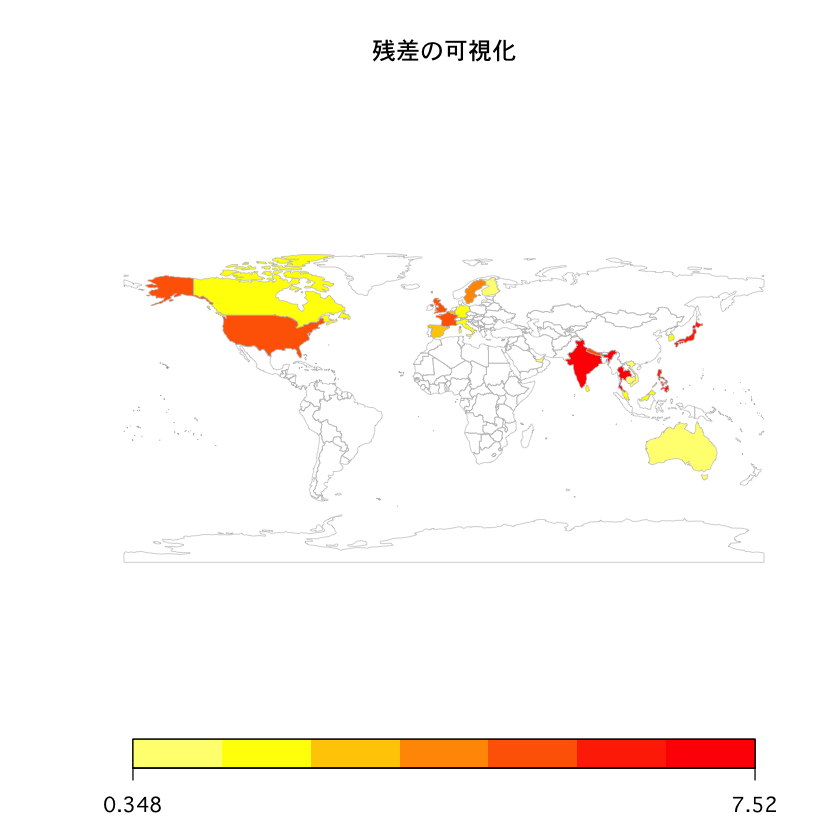

In [44]:
early_country$resid_abs <- abs(residuals(lm_early))

map_obj <- joinCountryData2Map(early_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid_abs"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=rev(heat.colors(7))
               , addLegend = TRUE)

### 晩期感染国

In [45]:
step(lm(date_first ~ hf + log(pop) + log(gdp) + urb + dist + log(air) + detection ,data = late_country))

Start:  AIC=500.58
date_first ~ hf + log(pop) + log(gdp) + urb + dist + log(air) + 
    detection

            Df Sum of Sq    RSS    AIC
- log(air)   1      0.00 5766.3 498.58
- hf         1     54.48 5820.7 499.77
<none>                   5766.3 500.58
- detection  1    137.44 5903.7 501.57
- dist       1    195.42 5961.7 502.81
- urb        1    286.73 6053.0 504.74
- log(gdp)   1    440.48 6206.7 507.93
- log(pop)   1    700.33 6466.6 513.14

Step:  AIC=498.58
date_first ~ hf + log(pop) + log(gdp) + urb + dist + detection

            Df Sum of Sq    RSS    AIC
- hf         1     54.54 5820.8 497.78
<none>                   5766.3 498.58
- detection  1    139.57 5905.8 499.62
- dist       1    195.71 5962.0 500.82
- urb        1    288.35 6054.6 502.78
- log(gdp)   1    545.54 6311.8 508.06
- log(pop)   1    960.74 6727.0 516.15

Step:  AIC=497.78
date_first ~ log(pop) + log(gdp) + urb + dist + detection

            Df Sum of Sq    RSS    AIC
<none>                   5820.8 497.78


Call:
lm(formula = date_first ~ log(pop) + log(gdp) + urb + dist + 
    detection, data = late_country)

Coefficients:
(Intercept)     log(pop)     log(gdp)          urb         dist    detection  
  1.453e+02   -1.938e+00   -3.854e+00   -1.147e-01    3.108e-07   -8.581e-02  


In [46]:
lm_late <- lm(formula = date_first ~ log(pop) + log(gdp) + urb + dist + detection, data = late_country)
summary(lm_late)
AIC(lm_late)


Call:
lm(formula = date_first ~ log(pop) + log(gdp) + urb + dist + 
    detection, data = late_country)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.9663  -4.9362  -0.0737   3.4829  23.3880 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.453e+02  1.173e+01  12.383  < 2e-16 ***
log(pop)    -1.938e+00  4.351e-01  -4.455 1.88e-05 ***
log(gdp)    -3.854e+00  9.737e-01  -3.958 0.000128 ***
urb         -1.147e-01  4.978e-02  -2.303 0.022971 *  
dist         3.108e-07  1.725e-07   1.802 0.074054 .  
detection   -8.581e-02  3.387e-02  -2.534 0.012568 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.936 on 121 degrees of freedom
Multiple R-squared:  0.5452,	Adjusted R-squared:  0.5264 
F-statistic: 29.01 on 5 and 121 DF,  p-value: < 2.2e-16


[1] 860.186

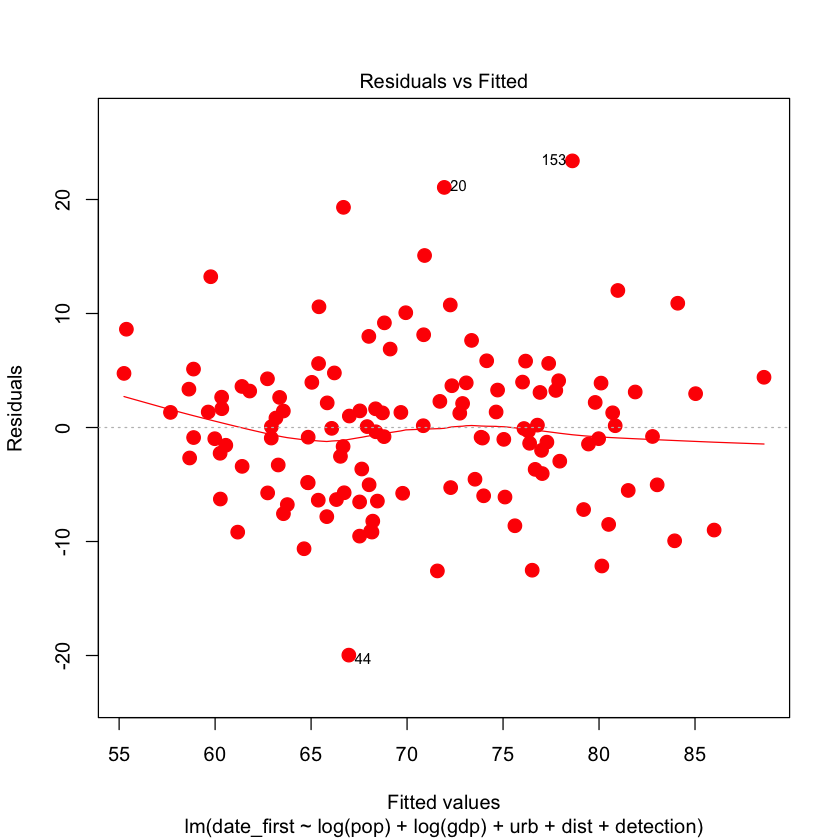

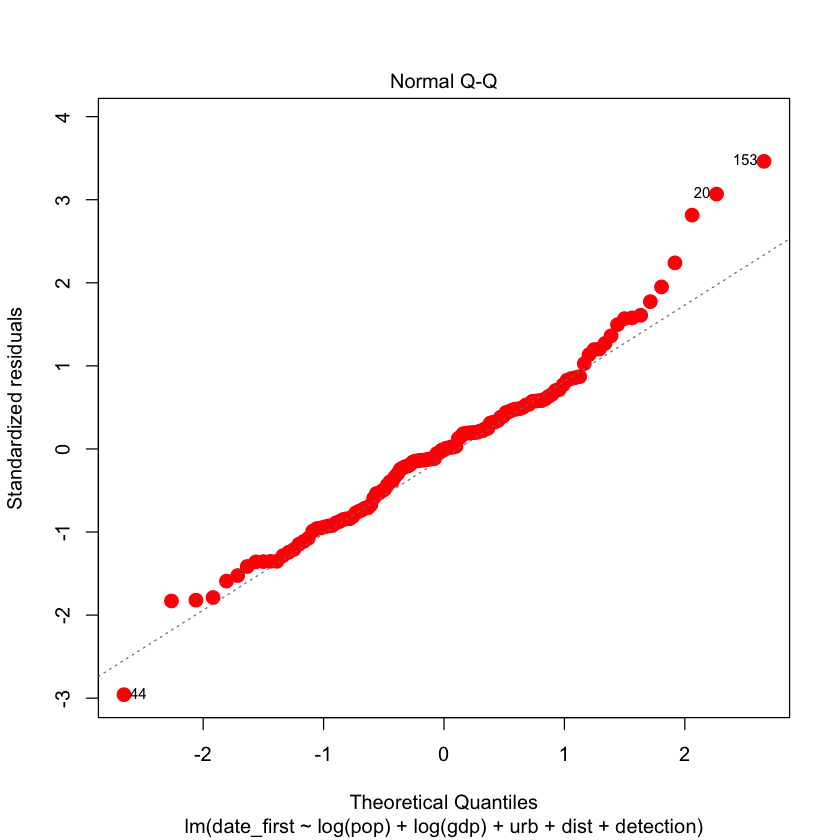

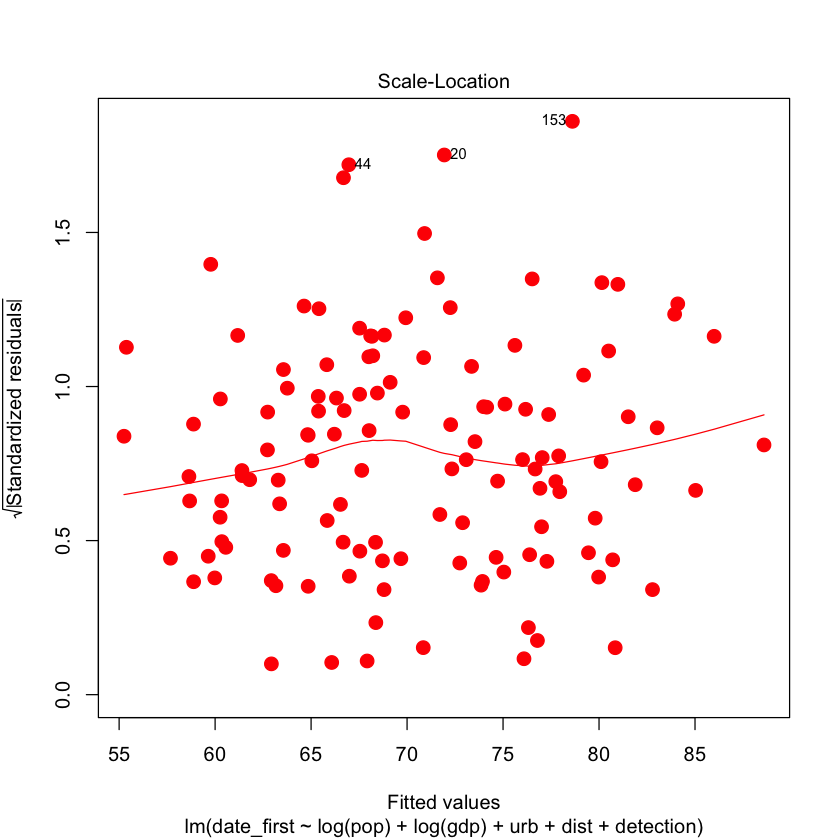

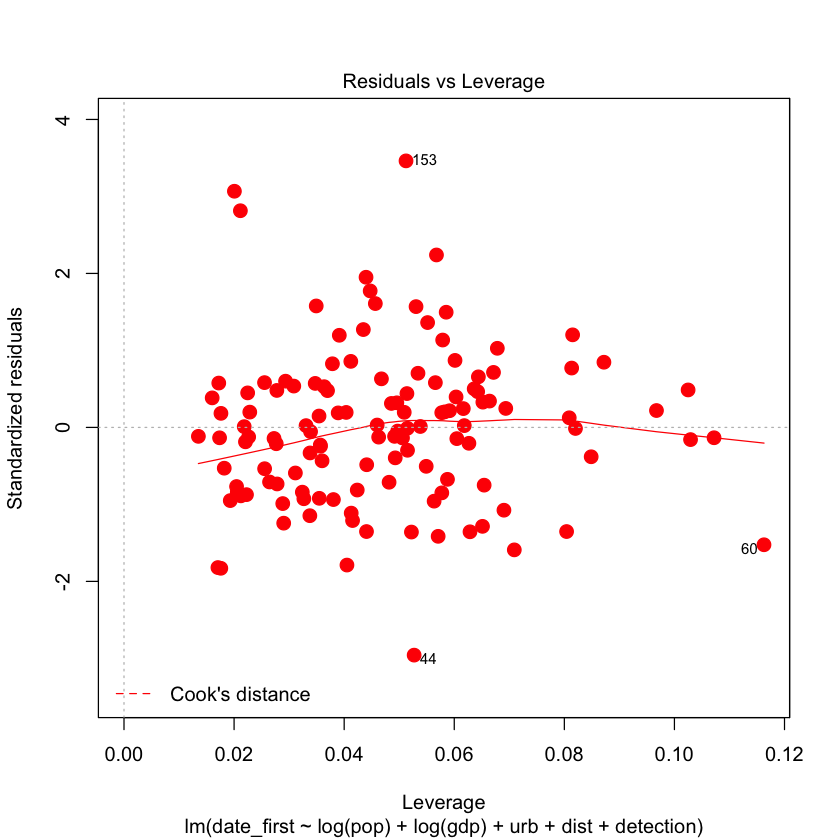

In [47]:
plot(lm_late,pch=21,bg=2,col=2,cex=1.5)

### 可視化からの考察  
- 残差はEgypt(44). Guyana(60), Yemen(153)が相対的に外れている

126 codes from your data successfully matched countries in the map
1 codes from your data failed to match with a country code in the map
117 codes from the map weren't represented in your data


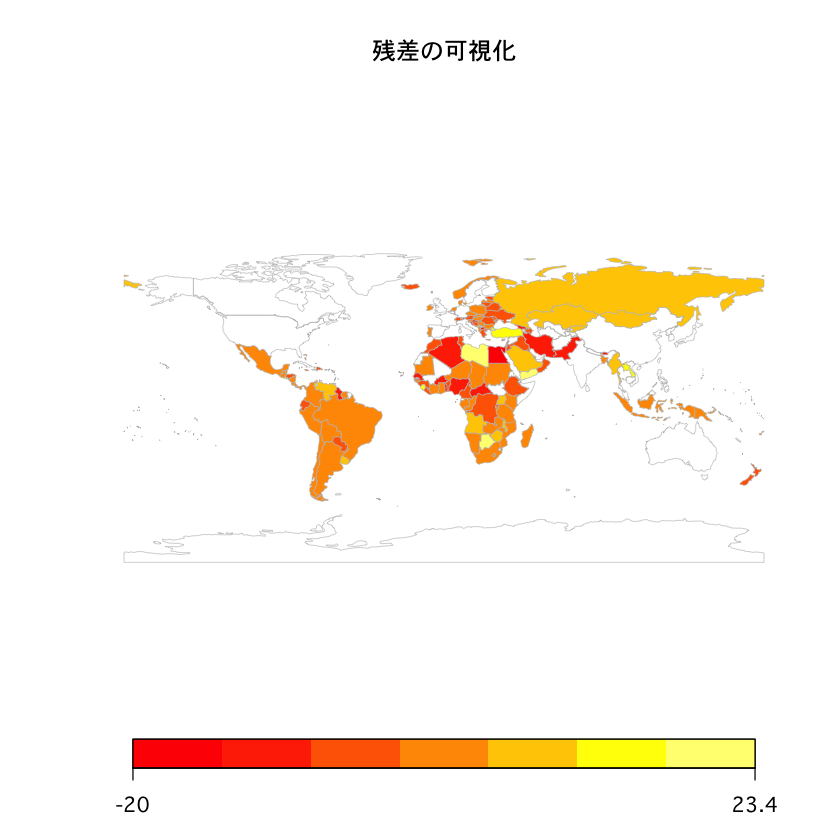

In [48]:
late_country$resid <- residuals(lm_late)

map_obj <- joinCountryData2Map(late_country, joinCode="NAME", nameJoinColumn="country")
par(family="Osaka")
mapCountryData(map_obj, nameColumnToPlot="resid"
               , mapTitle = "残差の可視化"
               , catMethod="fixedWidth"
               #, catMethod=c(45,60,75,90, 105)
               , colourPalette=heat.colors(7)
               , addLegend = TRUE)